This is another quick and handy utility function I often use. We're
going to wrap Keras's `model_to_dot` so that we can quickly visualize a model
without touching the disk, polluting our notebook's globals, and with some
opinionated default arguments. Naturally, customize this for your own
preferences.

First lets get some boilerplate imports out of the way. I'm using a stock
Tensorflow from pip that hasn't be specially built for my system, so I'll see a
lot of the common warnings that most of us see.

In [1]:
from typing import Optional
from pathlib import Path

from IPython.display import display, Image
import tensorflow as tf

2022-02-12 10:46:43.325689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 10:46:43.325712: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.




A quick google search "visualizing a Keras model" yields
`tf.keras.model_to_dot` which is a helpful utility that generates a `pydot`
graph representing the model. One needs to have the python libraries `pydot`
and `graphviz` installed for the function to work, which it reminds you of if
you don't have them installed. Now, I'd like to simply render the model in my
notebook rather than save it to a file (in most cases). I don't want to google
"write a `pydot` graph to svg" or "display a svg in Jupyter", which I'd likely
have to do once every couple of months. Instead, we just drop in a method that
9 times out of 10 will do exactly what we want so we can just keep rolling.

In [2]:
def display_model(
        model: tf.keras.Model,
        output_file: Optional[Path] = None,
        **mtd_kwds) -> None:
    """ Render the model in notebook

        [1]: https://keras.io/api/utils/model_plotting_utils/
        [2]: https://stackoverflow.com/a/18522941/2528639
    """
    kwds = {
        "dpi": 96*2,
        "expand_nested": True,
        "rankdir": "LR",
        "show_shapes": True,
    }
    kwds.update(mtd_kwds)
    # Some inputs aren't validated on the backend
    if kwds["rankdir"] not in {"LR", "TB"}:
        raise ValueError(
            f'Illegal value for keyword argument rankdir={kwds["rankdir"]}. '
            'Allowed values are LR or TB')

    pydot_graph = tf.keras.utils.model_to_dot(model, **kwds)
    png_str = pydot_graph.create_png(prog='dot')
    display(Image(png_str))

    if output_file is not None:
        pydot_graph.write(
            output_file, format=output_file.suffix[1:], prog=pydot_graph.prog)

Let's make a model that's just complicated enough that we'd appreciate some
form of visual aid. We have time series classification model with branching
paths. On one branch immediately apply a `LSTM` and then a dense layer. On
the other branch we apply a nested model at each time step using 
`TimeDistributed` before computing an aggregate inference through a GRU. The
two branches are then combined through max pooling and a final classification
layer generates the result.

The model itself is completely arbitrary and no activations or parameters are
based on any application. This is just for demonstration purposes so please
don't use this model for anything!

In [3]:
def intermediate_model(id: int):
    with tf.name_scope(f"I{id}") as scope:
        input_layer = tf.keras.layers.Input(batch_shape=(None, 8))
        L = input_layer
        L = tf.keras.layers.BatchNormalization()(L)
        L = tf.keras.layers.Dense(32)(L)
        L = tf.keras.layers.ReLU()(L)
        L = tf.keras.layers.Dropout(0.2)(L)
        L = tf.keras.layers.Dense(8)(L)
        return tf.keras.Model(inputs=input_layer, outputs=L, name=f"IModel-{id}")

def complex_model():
    input_time_series = tf.keras.layers.Input(batch_shape=(None, None, 8))
    branch_a = tf.keras.layers.LSTM(16)(input_time_series)
    branch_a = tf.keras.layers.Dense(8)(branch_a)
    branch_b = tf.keras.layers.TimeDistributed(intermediate_model(0), name="TDist-0")(input_time_series)
    branch_b = tf.keras.layers.GRU(8)(branch_b)
    merged = tf.stack([branch_a, branch_b], axis=1)
    merged = tf.keras.layers.MaxPool1D()(merged)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(merged)
    return tf.keras.Model(inputs=input_time_series, outputs=output, name="ArbitraryModel")

model = complex_model()

2022-02-12 10:46:44.951206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 10:46:44.951285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-12 10:46:44.951341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-12 10:46:44.951394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-02-12 10:46:44.951447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Let's see how the model renders using our opinionated defaults.

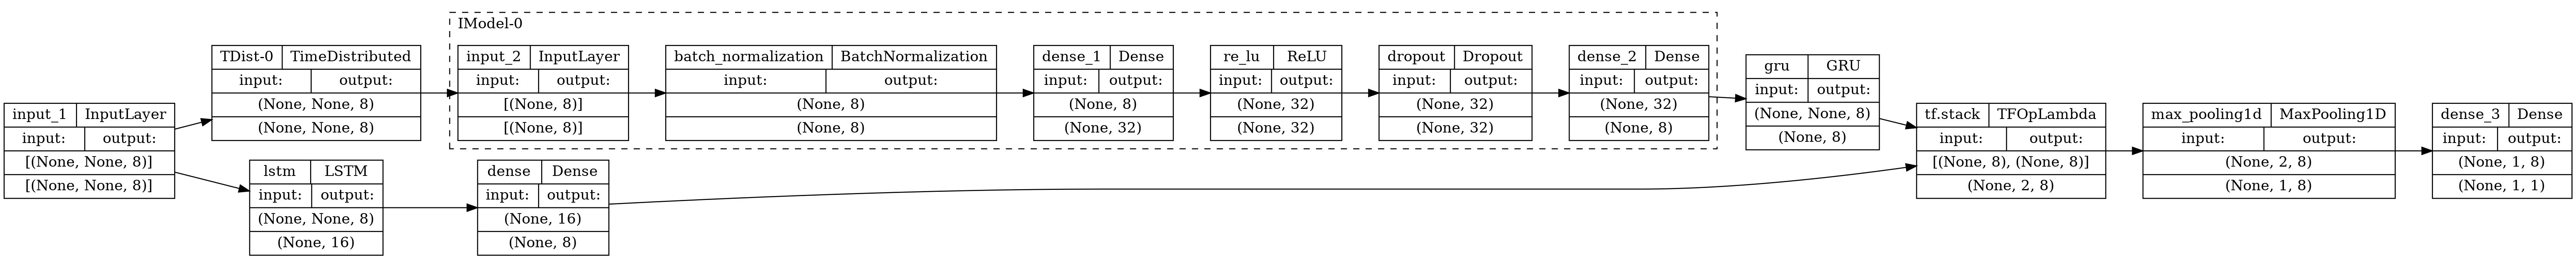

In [4]:
display_model(model)

Alright! We can clearly see the two branches as well as the nested model. With
the given defaults we also see the dimensions of each layer, which is handy for
debugging purposes. Normally I'm not calling this method because I wish to 
create something for a presentation. Unfortunately, `model_to_dot` suffers a
little if a model has multiple `TimeDistributed` calls or if you have custom
layers with internal nesting. Sometimes you can prize out results using
other keyword a arguments for our invocation (which we pass directly to
`model_to_dot`), but it's hit-or-miss.

# Conclusion

We've made a bite-sized utility function that one can easily drop into a
python notebook or a `keras.notebook` module within a larger project that saves
us a few google searches. We've attached some opinionated defaults to it so
that we're not looking up the module documentation to get things how we'll
typically use it, and we don't have to write any files to disk unless we want
to.

If you enjoy unnecessary deep dives or if you'd like to see other
content, [check out my blog](https://rob-hall.com/articles).